In [1]:
import numpy as np
import copy
from scipy.interpolate import CubicSpline
from scipy.integrate import quad
import scipy.stats as stats
from multiprocess import Pool
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Short Rate Calculation

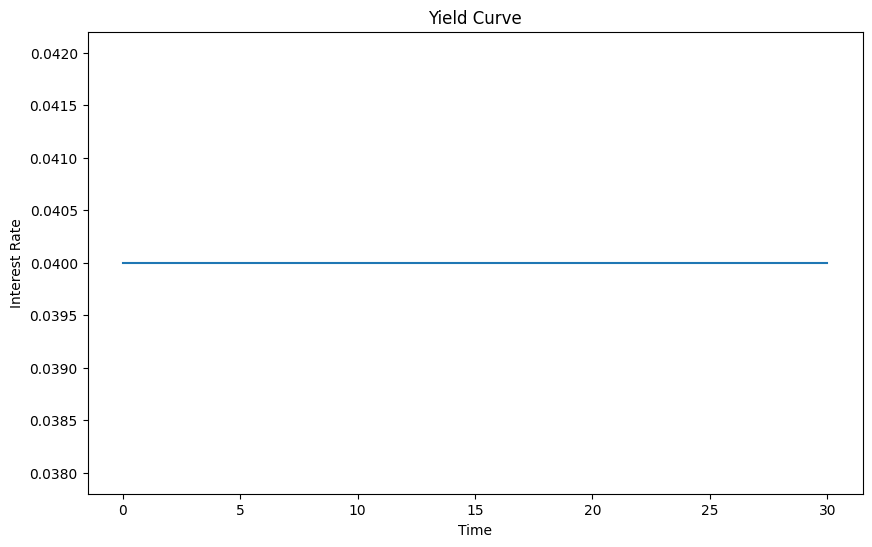

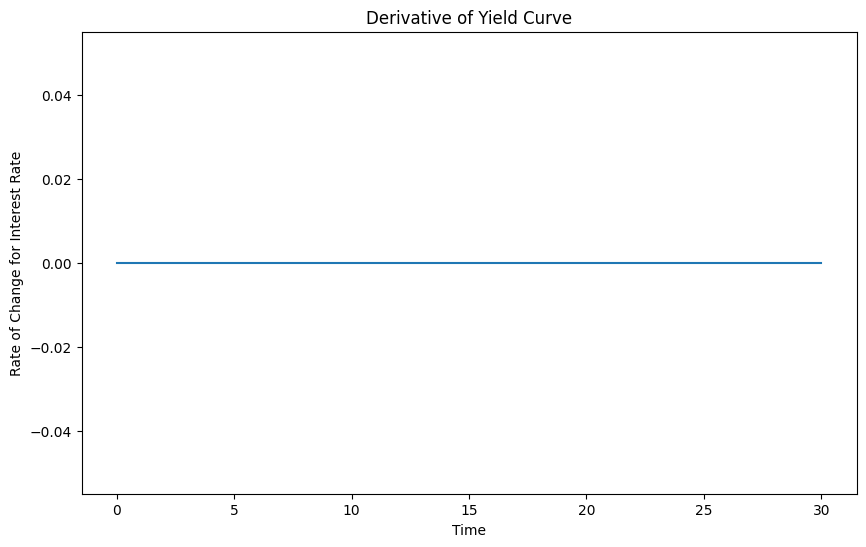

In [2]:
# Interest Rates
r0 = .04
# ECB Market Yield Curve on 7th November 2023 (Humped)
market_yields = [
    (0.25, .03708004),
    (0.50, .03480834),
    (0.75, .03205257),
    (1.0, .02944257),
    (2.0, .02342641),
    (3.0, .02264375),
    (4.0, .02372672),
    (5.0, .02519909),
    (6.0, .02661483),
    (7.0, .02786643),
    (8.0, .02894020),
    (9.0, .02984566),
    (10.0, .03059704),
    (11.0, .03120873),
    (12.0, .03169425),
    (13.0, .03206610),
    (14.0, .03233577),
    (15.0, .03251381),
    (16.0, .03260989),
    (17.0, .03263287),
    (18.0, .03259087),
    (19.0, .03249129),
    (20.0, .03234093),
    (21.0, .03214597),
    (22.0, .03191205),
    (23.0, .03164432),
    (24.0, .03134746),
    (25.0, .03102571),
    (26.0, .03068293),
    (27.0, .03032262),
    (28.0, .02994794),
    (29.0, .02956175),
    (30.0, .02916661),
]
# Flat Yield Curve
flat_yields = [
    (0.5, .04),
    (2.0, .04),
    (5.0, .04),
    (10.0, .04),
]
# Normal(Upward) Yield Curve
upward_yields = [
    (0.25, .041),
    (1.0, .042),
    (2.0, .043),
    (4.0, .044),
    (8.0, .0452),
    (12.0, .046),
    (24.0, .047),
    (30.0, .0471),
]
# Inverted Yield Curve
downward_yields = [
    (0.25, .039),
    (1.0, .038),
    (2.0, .037),
    (4.0, .036),
    (8.0, .0348),
    (12.0, .034),
    (24.0, .033),
    (30.0, .0329),
]

# Extract durations and yields
yield_curve = flat_yields
durations = [item[0] for item in yield_curve]
yields = [item[1] for item in yield_curve]

# Fit cubic spline
yield_curve = CubicSpline(durations, yields)

# Visualize the Fitted Curve
maturities = np.linspace(0.0, 30, 100)    # Generate 100 points (maturity time points) between 0.0 and 30.0
fitted_yields = yield_curve(maturities)   # Get the corresponding yields to maturity
plt.figure(1, figsize=(10,6))
plt.title("Yield Curve")
plt.xlabel("Time")
plt.ylabel("Interest Rate")
plt.plot(maturities, fitted_yields)

# Visualize the Fitted Curve dt
maturities = np.linspace(0.0, 30, 100)    # Generate 100 points (maturity time points) between 0.0 and 30.0
fitted_yields_dt = yield_curve.derivative(nu=1)(maturities)   # Get the corresponding yields to maturity
plt.figure(2, figsize=(10,6))
plt.title("Derivative of Yield Curve")
plt.xlabel("Time")
plt.ylabel("Rate of Change for Interest Rate")
plt.plot(maturities, fitted_yields_dt)

In [3]:
# Simulation's Parameters
T = 10                      # Years of Simulation
days_per_year = 365         # Days in the Year
steps = int(T*days_per_year)    # Number of steps
dt = 1.0 * T / steps            # Time step size
simulations = 1_000         # Amount of Monte Carlo runs
np.random.seed(42)

# Parameters for the Hull-White model
a = 0.05       # How fast is convergence to known rates. Typical Range: [0.01, 0.1]
sigma = 0.01   # Variance of rates. Typical range: [0.001, 0.02]
theta = lambda t: yield_curve.derivative(nu=1)(t) + (a*yield_curve(t)) + ((sigma**2)/(2*a))*(1-np.exp(-2*a*t))
r0 = 0.04

In [4]:
# I decided not to implement vectorized explicit formula (integrals still need for loop), so I parallelyzed drift generator
# Define the function that simulates a single path
def simulate_path(params):

    import numpy as np
    from scipy.interpolate import CubicSpline
    import scipy.stats as stats

    _, steps, dt, r0, a, sigma, theta, yield_curve = params
    theta = lambda t: yield_curve.derivative(nu=1)(t) + (a*yield_curve(t)) + ((sigma**2)/(2*a))*(1-np.exp(-2*a*t))
    
    Z = np.random.normal(0, 1, steps)
    dr = np.zeros(steps)
    r = np.zeros(steps)
    r[0] = r0  # Initialize with the initial rate from the market
    for t in range(1, steps):
        dr[t] = (theta(t * dt) - a * r[t-1]) * dt + sigma * np.sqrt(dt) * Z[t]
        r[t] = r[t-1] + dr[t]
    return r

# Use multiprocess to run simulations in parallel
simulation_params = [(i, steps, dt, r0, a, sigma, theta, yield_curve) for i in range(simulations)]

# Run in Parallel
with Pool() as pool:
    short_rate_paths = pool.map(simulate_path, simulation_params)

# Convert list of arrays to a 2D NumPy array
short_rate_paths = np.array(short_rate_paths)

# Swaption value calculation

In [5]:
# Swaption parameters
T_m = 5.0              # Maximum duration of swaption (Maturity)
pay_rate = 0.5          # Semi-Annual settlements (First settlement is assumed to be possible after this period too)
fixed_rate = 0.03   # Same as Strike Rate in simple options
N = 1                   # Notional Amount
short_rate_paths        # Already simulated paths for short rates

array([[0.04      , 0.04036056, 0.04065361, ..., 0.02755076, 0.02739923,
        0.02691295],
       [0.04      , 0.03967759, 0.03922489, ..., 0.01297566, 0.01314968,
        0.01345375],
       [0.04      , 0.03910774, 0.03842001, ..., 0.05520395, 0.05496465,
        0.05531146],
       ...,
       [0.04      , 0.04033838, 0.04065551, ..., 0.05090052, 0.05129427,
        0.05159973],
       [0.04      , 0.04005737, 0.03946045, ..., 0.06290657, 0.06217626,
        0.06195978],
       [0.04      , 0.0397218 , 0.03952803, ..., 0.00448845, 0.00478678,
        0.00517271]])

In [6]:
def simulate_swap_values(T_m, pay_rate, N, fixed_rate, short_rate_paths, days_per_year , yield_curve, a, sigma):

    # Swap Values calculator
    def sim_swap_eval(params):
        _, days_per_year, T_m, pay_rate, N, fixed_rate, short_rate_paths, yield_curve, a, sigma = params

        import numpy as np
        from scipy.interpolate import CubicSpline
        import scipy.stats as stats
        from scipy.integrate import quad

        # We have to redeclare functions for multiprocessing
        # Bond Evaluation
        def P(s, t, r, a, sigma, yield_curve):

            def A(s, t, a, sigma, yield_curve):
                theta = lambda t: yield_curve.derivative(nu=1)(t) + (a*yield_curve(t)) + ((sigma**2)/(2*a))*(1-np.exp(-2*a*t))
                integral, _ = quad(lambda u: (B(u, t, a) * theta(u)), s, t)
                term1 = sigma**2 / (2 * a**2)
                term2 = t - s + ((2/a) * np.exp(a * (s - t)))
                term3 = (1/(2 * a)) * np.exp(2 * a * (s - t))
                term4 = 3 / (2 * a)
                return np.exp(-integral - term1 * (term2 - term3 - term4))

            def B(s, t, a):
                return (1/a) * (1 - np.exp(a * (s - t)))
                
            return A(s, t, a, sigma, yield_curve) * np.exp(-B(s, t, a) * r)
        # Swap Evaluation
        def V(days_per_year, t, T_0, T_m, N, fixed_rate, pay_rate, rates, a, sigma, yield_curve):
            term1 = P(t, T_0, rates[int(days_per_year*t)], a, sigma, yield_curve)
            term2 = P(t, T_m, rates[int(days_per_year*t)], a, sigma, yield_curve)
            term3 = 0
            for T_i in np.arange(T_0+pay_rate, T_m+pay_rate, pay_rate):       # Value for all intermediate and last payout dates (np.arange does not include last term)
                term3 += P(t, T_i, rates[int(days_per_year*t)], a, sigma, yield_curve) * pay_rate
            return max(0, N*(term1 - term2 - fixed_rate*term3))    # Or is there any usability to keep negative cost?

        # Finding Swap Value for each possible exercise point
        swap_values = []
        for t in np.arange(0.0, T_m-pay_rate, pay_rate):     # Because of delay on starting of payments, we have less entries (Last one must be 2 pay_rates before Maturity9)
            swap_values.append(V(days_per_year, t, t+pay_rate, T_m, N, fixed_rate, pay_rate, short_rate_paths, a, sigma, yield_curve))
        return (swap_values)

    # Use multiprocess to run simulations in parallel
    simulation_params = [(i, days_per_year, T_m, pay_rate, N, fixed_rate, short_rate_paths[i], yield_curve, a, sigma) for i in range(simulations)]
    # Run in Parallel
    with Pool() as pool:
        simulations_swap_values = pool.map(sim_swap_eval, simulation_params)
    
    # Return list of arrays to a 2D NumPy array
    return np.array(simulations_swap_values)

In [7]:
def LSMC(simulations_swap_values, T_m, pay_rate):

    forward_rate_paths_regression = []
    for simulation in range(simulations):
        forward_rates_of_interest = []
        for t in np.arange(0.0, T_m-pay_rate, pay_rate):
            # To be clear what is counted where, made variables as explicit as possible
            start_id = int(days_per_year*t)
            finish_id = int(days_per_year*(t+pay_rate))
            forward_rate = np.sum(short_rate_paths[simulation, start_id:finish_id]*dt)  # Using Reimann sum to approximate the integral for rates
            forward_rates_of_interest.append(forward_rate)
        forward_rate_paths_regression.append(forward_rates_of_interest)
    forward_rate_paths_regression = np.array(forward_rate_paths_regression)         # r_s for Regression

    # Regressing and Finding optimal points to enter swap with fair value
    simulations_swap_values_reg = copy.deepcopy(simulations_swap_values)        # So we do not have to rerun pricing of swaps
    for i in reversed(range(0, simulations_swap_values_reg.shape[1]-1)):
        ids_to_fit = np.where(simulations_swap_values_reg[:, i] > 0)        # Creating mask to regress only "in money" options
        ids_to_fit = ids_to_fit[0]
        if np.any(ids_to_fit):
            Y = simulations_swap_values_reg[ids_to_fit, i+1]*np.exp(-forward_rate_paths_regression[ids_to_fit, i]*pay_rate).reshape(-1,1)      # Target (V(t+1)*exp(-r_s(t)*dt)), dt is payoff_rate, (d_i to be precise)
            X_pred = forward_rate_paths_regression[ids_to_fit, i].reshape(-1,1)                                                   # Train  (r_s(t))
            model = LinearRegression().fit(X_pred, Y)                               # For now it is just 1d linear regression, should try polynomial and more time entries to improve accuracy
            continuation_values = model.predict(simulations_swap_values_reg[ids_to_fit, i].reshape(-1,1))
            continuation_values = continuation_values[0]        # Return of regression is duplicated, because it is 1D

            for j in range(continuation_values.shape[0]):
                #print(continuation_values[j], " vs ", simulations_swap_values_reg[ids_to_fit[j], i])
                if continuation_values[j] > simulations_swap_values_reg[ids_to_fit[j], i]:
                    simulations_swap_values_reg[ids_to_fit[j],i] = 0.0
                else: simulations_swap_values_reg[ids_to_fit[j],i+1:] = 0.0

    # Finding fair value for each swap value path
    fair_values_t = []
    for sim in range(simulations):
        max_index = np.argmax(simulations_swap_values_reg[sim])
        max_value = simulations_swap_values_reg[sim][max_index]
        disc_rate = forward_rate_paths_regression[sim, max_index]
        max_value_fair = max_value*np.exp(-disc_rate*(max_index*pay_rate))        # dt cancels with days per year, obviously
        fair_values_t.append(max_value_fair)
    fair_value_t = np.mean(fair_values_t)

    return fair_value_t

# Finding Greeks

### Delta

In [8]:
# We should ask Jori, about greeks this week, if we do everything correctly (We indeed did it all wrong)
def calc_delta(T_m, pay_rate, N, fixed_rate, short_rate_paths, days_per_year , yield_curve, a, sigma):
    epsilon = 1e-6
    normal_swap = simulate_swap_values(T_m, pay_rate, N, fixed_rate, short_rate_paths, days_per_year , yield_curve, a, sigma)
    error_swap = simulate_swap_values(T_m, pay_rate, N, fixed_rate, short_rate_paths+epsilon, days_per_year , yield_curve, a, sigma)

    normal_price = LSMC(normal_swap, T_m, pay_rate)
    print("Normal Price", normal_price)

    error_price = LSMC(error_swap, T_m, pay_rate)
    print("Price with Error", error_price)

    return (error_price - normal_price) / epsilon

In [9]:
calc_delta(T_m, pay_rate, N, fixed_rate, short_rate_paths, days_per_year , yield_curve, a, sigma)

Normal Price 0.04877714643289565
Price with Error 0.048780477754434


3.3313215383468098

### Gamma (Did not update for new parallel func)

In [10]:
def calc_gamma(short_rate_paths):
    epsilon = 1e-8
    normal_swap = simulate_swap_values(short_rate_paths)
    positive_swap = simulate_swap_values(short_rate_paths + epsilon)
    negative_swap = simulate_swap_values(short_rate_paths - epsilon)

    normal_price = LSMC(normal_swap)
    negative_price = LSMC(negative_swap)
    positive_price = LSMC(positive_swap)

    print(normal_price)
    print(negative_price)
    print(positive_price)

    return (positive_price - 2 * normal_price + negative_price) / (epsilon ** 2)

In [11]:
calc_gamma(short_rate_paths)

TypeError: simulate_swap_values() missing 8 required positional arguments: 'pay_rate', 'N', 'fixed_rate', 'short_rate_paths', 'days_per_year', 'yield_curve', 'a', and 'sigma'

### Vega (Did not update for new parallel func)

In [ ]:
epsilon = 0.0001

In [ ]:
paths_epsilon = []
for n in range(simulations):
    Z = np.random.normal(0, 1, N)
    dr = np.zeros(N)
    r = np.zeros(N)
    r[0] = r0              # Should we initialize with initial rate from the market?
    for t in range(1, N):
        dr[t] = (theta(t * dt) - a * r[t-1]) * dt + (sigma + epsilon) * np.sqrt(dt) * Z[t]
        r[t] = r[t-1] + dr[t]
    paths_epsilon.append(r)
paths_epsilon = np.array(short_rate_paths)

In [ ]:
def calc_vega(short_rate_paths, paths_epsilon, simulations, T_m, pay_rate, N, fixed_rate, epsilon):
    normal_swap = simulate_swap_values(short_rate_paths)
    error_swap = simulate_swap_values(paths_epsilon)

    normal_price = LSMC(normal_swap)
    error_price = LSMC(error_swap)

    return (error_price - normal_price) / epsilon

In [ ]:
calc_vega(short_rate_paths, paths_epsilon, simulations, T_m, pay_rate, N, fixed_rate, epsilon)

### Theta (Did not update for new parallel func)

In [ ]:
def calc_theta(short_rate_paths):
    normal_swap = simulate_swap_values(short_rate_paths)
    error_swap = simulate_swap_values(short_rate_paths)

    normal_price = LSMC(normal_swap)
    error_price = LSMC(error_swap)

    return (error_price - normal_price) / dt